In [34]:
# %pip install pandas
# %pip install openpyxl
# %pip install transformers torch scikit-learn
# %pip install torch==2.2.0
# %pip install seaborn matplotlib
%pip install flask

In [30]:
import pandas as pd
import numpy as np
import string
import re
import tqdm

from sklearn.preprocessing import LabelEncoder
from transformers import AdamW, AutoModelForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import torch
from transformers import AutoTokenizer
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('../nckhsv_2023.xlsx')
df.columns = ['Content', 'Conclusion', 'Người thu thập']
df = df.drop(columns=['Người thu thập'])
df = df.drop(0)
df

,Content,Conclusion
1,Dạ ac cho e hỏi là e là SV năm nhất nhưng em đ...,Yes
2,Đêm về mong nhớ không xong rồi anh lỡ trao trá...,No
3,Cho e hỏi đi hk quân sự là hk tại trường 1 thá...,Yes
4,Tuy mờ vaio nhưng mà vẫn muốn xin inf bạn nữ đ...,No
5,Cho e hỏi nên học tiếng anh ở trường k ạ,Yes
...,...,...
4565,"Góc nhượng phòng: \nChào mọi người, mình muốn ...",No
4566,Tìm phòng ở ghép ạ\nem là svien K64 neu \ncó a...,No
4567,🐮 Góc tìm roommate \nHiện tại tớ là nữ K64 muố...,No
4568,Mình vừa đi đổi size quân phục và nhận ra mình...,No


In [3]:
df['Content'] = df['Content'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [4]:
def remove_punctuation(text):
    if isinstance(text, str):
        for i in string.punctuation:
            if i in text:
                text = text.replace(i,'')        
    return text

df['Content'] = df['Content'].apply(remove_punctuation)

In [5]:
def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

df['Content'] = df['Content'].apply(lambda x: remove_emoji(str(x)))

In [6]:
df['Content'] = df['Content'].astype(str)

# Điền giá trị NaN vào các ô dữ liệu bị thiếu
df['Content'] = df['Content'].fillna('')

# Áp dụng hàm loại bỏ khoảng trắng thừa vào cột 'Ten'
df['Content'] = df['Content'].apply(lambda x: re.sub('\s+', ' ', x).strip())

df.head()

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Asus\AppData\Local\Temp\ipykernel_144\1054685402.py:7: SyntaxWarning: invalid escape sequence '\s'
  df['Content'] = df['Content'].apply(lambda x: re.sub('\s+', ' ', x).strip())


,Content,Conclusion
1,dạ ac cho e hỏi là e là sv năm nhất nhưng em đ...,Yes
2,đêm về mong nhớ không xong rồi anh lỡ trao trá...,No
3,cho e hỏi đi hk quân sự là hk tại trường 1 thá...,Yes
4,tuy mờ vaio nhưng mà vẫn muốn xin inf bạn nữ đ...,No
5,cho e hỏi nên học tiếng anh ở trường k ạ,Yes


In [7]:
def remove_abb(data):
    data = re.sub(r"\bko\b", "không", data)
    data = re.sub(r"\bmk\b", "mình", data)
    data = re.sub(r"\be\b", "em", data)
    data = re.sub(r"\biu\b", "yêu", data)
    data = re.sub(r"\bb\b", "bạn", data)
    data = re.sub(r"\bad\b", "admin", data)
    data = re.sub(r"\bng\b", "người", data)
    data = re.sub(r"\bhh\b", "học hộ", data)
    data = re.sub(r"\bcnxh\b", "chủ nghĩa xã hội", data)
    data = re.sub(r"\bbhyt\b", "bảo hiểm y tế", data)
    data = re.sub(r"\bbt\b", "biết", data)
    data = re.sub(r"\bib\b", "inbox", data)
    data = re.sub(r"\bin4\b", "info", data)
    data = re.sub(r"\bktx\b", "kí túc xá", data)
    data = re.sub(r"\bny\b", "người yêu", data)
    data = re.sub(r"\bvc\b", "việc", data)
    data = re.sub(r"\btrg\b", "trường", data)
    data = re.sub(r"\bfb\b", "facebook", data)
    data = re.sub(r"\bmn\b", "mọi người", data)
    data = re.sub(r"\bib\b", "inbox", data)
    data = re.sub(r"\bqldt\b", "quản lý đào tạo", data)
    data = re.sub(r"\bk\b", "không", data)
    data = re.sub(r"\bđc\b", "được", data)
    data = re.sub(r"\bak\b", "ạ", data)
    data = re.sub(r"\bm\b", "mình", data)
    data = re.sub(r"\banqp\b", "an ninh quốc phòng", data)
    data = re.sub(r"\bgdtc\b", "giáo dục thể chất", data)
    data = re.sub(r"\bbb\b", "bạn bè", data)
    data = re.sub(r"\ba.c\b", "anh chị", data)
    data = re.sub(r"\bac\b", "anh chị", data)
    data = re.sub(r"\bng\b", "người", data)
    data = re.sub(r"\bntnt\b", "như thế nào", data)
    data = re.sub(r"\br\b", "rồi", data)
    data = re.sub(r"\bhok\b", "học", data)
    data = re.sub(r"\btp\b", "thành phần", data)
    data = re.sub(r"\bh\b", "giờ", data)
    data = re.sub(r"\bace\b", "anh chị em", data)
    data = re.sub(r"\bbâyh\b", "bây giờ", data)
    data = re.sub(r"\bm.n\b", "mọi người", data)
    data = re.sub(r"\ba/c\b", "anh chị", data)
    data = re.sub(r"\btl\b", "trả lời", data)
    data = re.sub(r"\bbh\b", "bây giờ", data)
    data = re.sub(r"\ba\b", "anh", data)
    data = re.sub(r"\ba/c/e\b", "anh chị em", data)
    data = re.sub(r"\bxl\b", "xin lỗi", data)
    #data = re.sub(r"\bđk\b", "đăng ký")
    data = re.sub(r"\bô\b", "ông", data)
    #data = re.sub(r"\bsđt\b", "số điện thoại", data)
    data = re.sub(r"\bgd\b", "gia đình", data)
    data = re.sub(r"\bđki\b", "đăng ký", data)
    data = re.sub(r"\bcmt\b", "bình luận", data)
    data = re.sub(r"\bnt\b", "nhắn tin", data)
    data = re.sub(r"\bhk\b", "học kỳ", data)
    data = re.sub(r"\btnao\b", "thế nào", data)
    data = re.sub(r"\bt.p\b", "thành phần", data)
    data = re.sub(r"\bdstt\b", "đại số tuyến tính", data)
    data = re.sub(r"\bvly\b", "vật lý", data)
    data = re.sub(r"\bbtl\b", "bài tập lớn", data)
    data = re.sub(r"\bhnay\b", "hôm nay", data)
    data = re.sub(r"\bsv\b", "sinh viên", data)
    data = re.sub(r"\bsp\b", "hỗ trợ", data)
    data = re.sub(r"\bdkk\b", "được", data)
    data = re.sub(r"\brr\b", "rời rạc", data)
    data = re.sub(r"\biem\b", "em", data)
    data = re.sub(r"\bclb\b", "câu lạc bộ", data)
    data = re.sub(r"\bmik\b", "mình", data)
    data = re.sub(r"\bcfs\b", "confession", data)
    data = re.sub(r"\bwen\b", "quen", data)
    data = re.sub(r"\bcc\b", "chứng chỉ", data)
    return data

df['Content'] = df['Content'].apply(remove_abb)
df.head()

,Content,Conclusion
1,dạ anh chị cho em hỏi là em là sinh viên năm n...,Yes
2,đêm về mong nhớ không xong rồi anh lỡ trao trá...,No
3,cho em hỏi đi học kỳ quân sự là học kỳ tại trư...,Yes
4,tuy mờ vaio nhưng mà vẫn muốn xin inf bạn nữ đ...,No
5,cho em hỏi nên học tiếng anh ở trường không ạ,Yes


In [8]:
labelEncoder = LabelEncoder()
df['Conclusion'] = labelEncoder.fit_transform(df['Conclusion'])
df = df.drop(df[(df['Conclusion'] == 2) | (df['Conclusion'] == 3)].index)
df['Conclusion'].unique()

array([1, 0])

In [10]:
max_len = 0
for index, row in df.iterrows():
    text_len = len(row['Content'])
    if text_len > max_len:
        max_len = text_len

print(max_len)

6706


In [9]:
# Step 2: Tokenization and Encoding

tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')

tokens = tokenizer.batch_encode_plus(
    df['Content'].tolist(),
    padding="max_length",
    truncation=True,
    max_length=256,
    return_tensors='pt',
)

print(tokens)

input_ids = tokens['input_ids']
token_type_ids = tokens['token_type_ids']
attention_mask = tokens['attention_mask']

{'input_ids': tensor([[    0, 10705,    83,  ...,     1,     1,     1],
        [    0,   396,    28,  ...,     1,     1,     1],
        [    0,    13,   193,  ...,     1,     1,     1],
        ...,
        [    0,  1638,   240,  ...,     1,     1,     1],
        [    0,    68,   164,  ...,     1,     1,     1],
        [    0,    40,   829,  ...,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [10]:
print(input_ids.shape)
print(token_type_ids.shape)
print(attention_mask.shape)

torch.Size([4544, 256])
torch.Size([4544, 256])
torch.Size([4544, 256])


In [11]:
# Step 3: Splitting the Data
train_size = int(0.8 * len(df['Content'].tolist()))
train_input_ids = torch.tensor(input_ids[:train_size])
train_attention_mask = torch.tensor(attention_mask[:train_size])
train_token_type_ids = torch.tensor(token_type_ids[:train_size])
train_labels = torch.tensor(df['Conclusion'].tolist()[:train_size])

print(train_input_ids.shape)
print(train_attention_mask.shape)
print(train_labels.shape)
print(train_token_type_ids.shape)

val_input_ids = torch.tensor(input_ids[train_size:])
val_attention_mask = torch.tensor(attention_mask[train_size:])
val_token_type_ids = torch.tensor(token_type_ids[train_size:])
val_labels = torch.tensor(df['Conclusion'].tolist()[train_size:])

torch.Size([3635, 256])
torch.Size([3635, 256])
torch.Size([3635])
torch.Size([3635, 256])


C:\Users\Asus\AppData\Local\Temp\ipykernel_144\3351076661.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_input_ids = torch.tensor(input_ids[:train_size])
C:\Users\Asus\AppData\Local\Temp\ipykernel_144\3351076661.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_attention_mask = torch.tensor(attention_mask[:train_size])
C:\Users\Asus\AppData\Local\Temp\ipykernel_144\3351076661.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_token_type_ids = torch.tensor(token_type_ids[:train_size])
C:\Users\Asus\AppData\Local\T

In [12]:
# Step 4: Creating Datasets and Data Loaders
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)

batch_size = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(train_dataloader)

In [13]:
# Step 5: Model Initialization and Optimizer
num_classes = 2

from transformers import AutoConfig

model = AutoModelForSequenceClassification.from_pretrained('vinai/phobert-base')
optimizer = AdamW(model.parameters(), lr=2e-5)




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
# print(model)
# for name, param in model.named_parameters():
#     print(name, param.shape)

model.config.max_position_embeddings = 256
# model.config.vocab_size = len(tokenizer)
# model.config.vocab_size


In [15]:
# for name, param in model.named_parameters():
#     print(name, param.shape)
print(model.config.max_position_embeddings)

256


In [16]:
num_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_dataloader:
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)
        batch_labels = batch_labels.to(device)

        
        optimizer.zero_grad()
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)

        logits = outputs.logits
        loss = criterion(logits, batch_labels)  # Sử dụng hàm mất mát CrossEntropyLoss

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    # Validation and Evaluation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_true = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = batch
            batch_input_ids = batch_input_ids.to(device)
            batch_attention_mask = batch_attention_mask.to(device)
            batch_labels = batch_labels.to(device)
            
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
            logits = outputs.logits

            loss = criterion(logits, batch_labels)  
            val_loss += loss.item()

            _, preds = torch.max(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(batch_labels.cpu().numpy())

        val_loss /= len(val_dataloader)
        val_acc = accuracy_score(val_true, val_preds)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}')

Epoch 1/3
Train loss: 0.4157 | Val loss: 0.3709 | Val accuracy: 0.8328
Epoch 2/3
Train loss: 0.3404 | Val loss: 0.3424 | Val accuracy: 0.8383
Epoch 3/3
Train loss: 0.3040 | Val loss: 0.3444 | Val accuracy: 0.8240


In [26]:
import pickle

with open('modelBert.pkl', 'wb') as f:
    pickle.dump(model, f)

In [36]:
print(torch.__version__)

2.3.0+cpu


In [25]:
# Save model:
torch.save(model.state_dict(), 'ten_file.pth')

In [33]:
# Load lại model:
check_point = torch.load('ten_file.pth')
modelBert = AutoModelForSequenceClassification.from_pretrained('vinai/phobert-base')
modelBert.load_state_dict(check_point)

# Đảm bảo rằng mô hình đã được chuyển đến cùng một thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

val_preds = []
val_true = []

with torch.no_grad():
    for batch in val_dataloader:
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)
        
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(batch_labels.cpu().numpy())

# Tính toán các độ đo đánh giá
accuracy = accuracy_score(val_true, val_preds)
precision = precision_score(val_true, val_preds)
recall = recall_score(val_true, val_preds)
f1 = f1_score(val_true, val_preds)
conf_matrix = confusion_matrix(val_true, val_preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion matrix:\n", conf_matrix)

Accuracy: 0.823982398239824
Precision: 0.5582191780821918
Recall: 0.8402061855670103
F1-score: 0.6707818930041153
Confusion matrix:
 [[586 129]
 [ 31 163]]


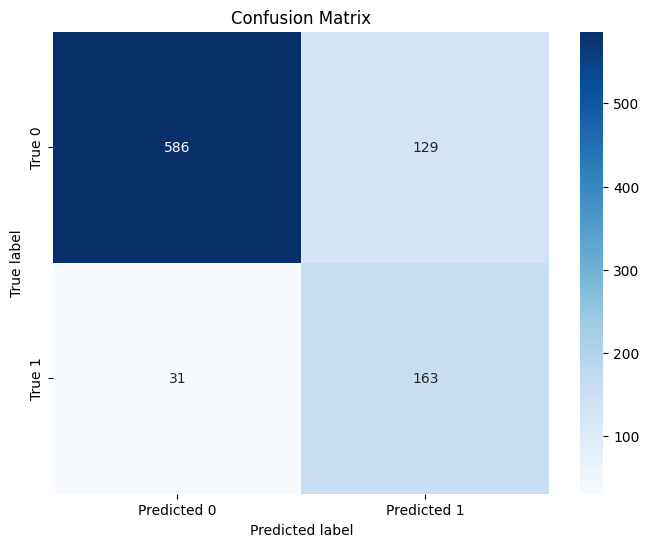

In [31]:
# Tính toán confusion matrix
conf_matrix = confusion_matrix(val_true, val_preds)

# Tạo DataFrame từ confusion matrix
conf_df = pd.DataFrame(conf_matrix, index = ['True 0', 'True 1'], columns = ['Predicted 0', 'Predicted 1'])

# Vẽ heatmap với seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [38]:
import flask

app = flask.Flask(__name__)

def preprocessData(x):
    x = x.lower() if isinstance(x, str) else x
    if isinstance(x, str):
        for i in string.punctuation:
            if i in x:
                x = x.replace(i,'')
    x = remove_emoji(x)
    x = remove_abb(x)
    return x
    

@app.post('/predict')
def predict():
    data = flask.request.json

    text = data["text"]
    text = preprocessData(text)
    text = tokenizer.batch_encode_plus(text, padding="max_length", truncation=True, max_length=256, return_tensors='pt')

    input_ids = text['input_ids']
    attention_mask = text['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)

    predicted_class = torch.argmax(probabilities, dim=1).item()

    # Trả về kết quả dự đoán dưới dạng JSON
    return flask.jsonify({'predicted_class': predicted_class})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1